In [40]:
import numpy as np
import math
import pandas as pd
from molvs import standardize_smiles
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.preprocessing import StandardScaler

In [27]:
#In future put all of this in preprocessing notebook
df_ilcom = pd.read_csv('data/commercial-il.tsv', delimiter='\t')
df_cat = pd.read_csv('data/cations.tsv', delimiter='\t')
df_an = pd.read_csv('data/anions.tsv', delimiter='\t')

In [28]:
desc_names = [x[0] for x in Descriptors._descList]
def calc_descriptors(smiles):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)
    mol = Chem.MolFromSmiles(smiles)
    desc = calc.CalcDescriptors(mol)
    return desc

In [29]:
df_ilcom_desc = pd.concat(
    [
        pd.DataFrame(df_ilcom['cation'].apply(calc_descriptors).tolist(), columns=desc_names).add_suffix('_cation'),
        pd.DataFrame(df_ilcom['anion'].apply(calc_descriptors).tolist(), columns=desc_names).add_suffix('_anion')
    ],
    axis=1
).fillna(0)

df_ilcom_desc = df_ilcom_desc.loc[:,df_ilcom_desc.nunique()>1]

In [30]:
scaler = StandardScaler()
ilcom_desc_norm = scaler.fit_transform(df_ilcom_desc)
df_ilcom_desc = pd.DataFrame(ilcom_desc_norm, columns=df_ilcom_desc.columns)

df_ilcom_desc

,MaxAbsEStateIndex_cation,MaxEStateIndex_cation,MinAbsEStateIndex_cation,MinEStateIndex_cation,qed_cation,SPS_cation,MolWt_cation,HeavyAtomMolWt_cation,ExactMolWt_cation,NumValenceElectrons_cation,...,fr_ether_anion,fr_halogen_anion,fr_isothiocyan_anion,fr_methoxy_anion,fr_nitrile_anion,fr_phos_acid_anion,fr_phos_ester_anion,fr_sulfonamd_anion,fr_thiocyan_anion,fr_unbrch_alkane_anion
0,-0.233980,-0.233980,0.103143,0.217055,-0.002761,-0.346589,-0.520843,-0.510477,-0.520482,-0.498584,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,-0.133856
1,-0.233980,-0.233980,0.103143,0.217055,-0.002761,-0.346589,-0.520843,-0.510477,-0.520482,-0.498584,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,6.016287
2,-0.233980,-0.233980,0.103143,0.217055,-0.002761,-0.346589,-0.520843,-0.510477,-0.520482,-0.498584,...,6.798693,-1.082053,-0.068761,6.798693,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,-0.133856
3,-0.233980,-0.233980,0.103143,0.217055,-0.002761,-0.346589,-0.520843,-0.510477,-0.520482,-0.498584,...,-0.147087,0.012882,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,-0.133856
4,-0.233980,-0.233980,0.103143,0.217055,-0.002761,-0.346589,-0.520843,-0.510477,-0.520482,-0.498584,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,-0.133856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,-1.622775,-1.622775,-2.676922,-1.444253,-1.006859,-1.982162,-1.072175,-1.000368,-1.088818,-1.728114,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,-0.133856
421,-1.622775,-1.622775,-2.676922,-1.444253,-1.006859,-1.982162,-1.072175,-1.000368,-1.088818,-1.728114,...,-0.147087,1.107817,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,1.889416,-0.068761,-0.133856
422,-1.622775,-1.622775,-2.676922,-1.444253,-1.006859,-1.982162,-1.072175,-1.000368,-1.088818,-1.728114,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,-0.133856
423,-1.622775,-1.622775,-2.676922,-1.444253,-1.006859,-1.982162,-1.072175,-1.000368,-1.088818,-1.728114,...,-0.147087,0.012882,-0.068761,-0.147087,-0.205704,-0.15523,-0.147087,-0.529264,-0.068761,-0.133856


In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components=50)
pca.fit(df_ilcom_desc)

pca_evr = pca.explained_variance_ratio_
cumsum = np.cumsum(pca_evr)

# Get dimensions where var >= 95% and values for variance at 2D, 3D
dim_95 = np.argmax(cumsum >= 0.95) + 1
twoD = np.round(cumsum[1], decimals=3)*100 
threeD = np.round(cumsum[2], decimals=3)*100

print(
    f'95% of variance can be explained with {dim_95} principal components\n',
    f'First two principal components explain {twoD}% variance\n',
    f'First three principal components explain {threeD}% variance'
)

ilcom_pca = pca.transform(df_ilcom_desc)[:,:dim_95]

95% of variance can be explained with 37 principal components
 First two principal components explain 31.7% variance
 First three principal components explain 40.2% variance


In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')

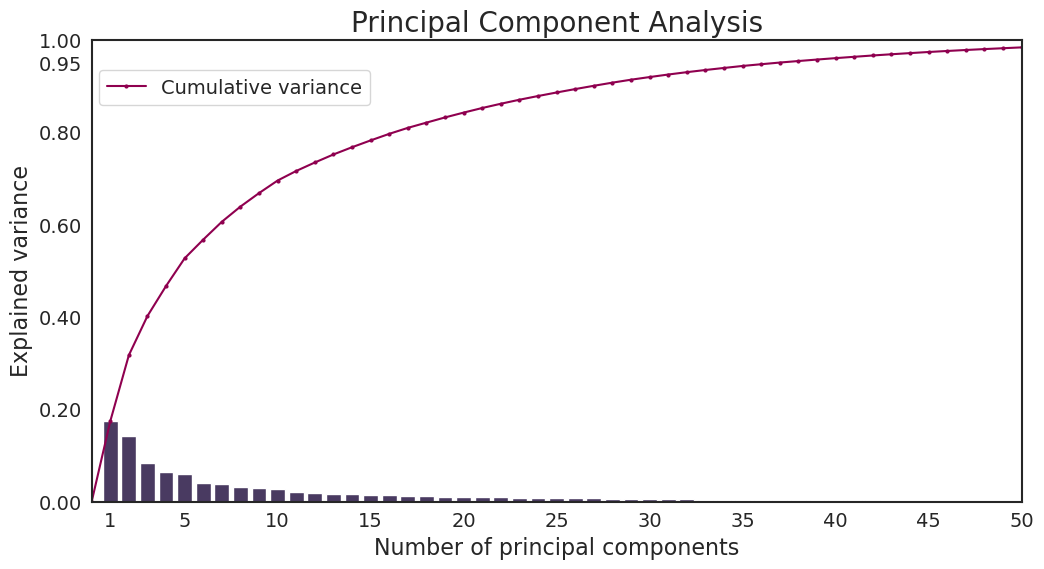

In [34]:
plt.figure(figsize=(12, 6))

plot = sns.barplot(x=[i for i in range(len(pca_evr)+1)], y=np.insert(pca_evr,0,0), color='#473367')
plt.plot([i for i in range(len(pca_evr)+1)], np.insert(pca_evr.cumsum(),0,0), color='#8F004F', marker='o', markersize=2, label='Cumulative variance')

# Add labels and legend
plt.title('Principal Component Analysis', 
   # fontweight='bold',
    fontsize=20,
)
plt.ylabel('Explained variance', 
           fontsize=16
)
plt.xlabel('Number of principal components',
           fontsize=16
)
plt.xlim(0,50)
plt.ylim(0,1)

xticks=[x for x in range(0, 51, 1)]
plt.xticks(
    ticks=xticks,
    labels=[f'{x}' if x in [i for i in range(5, 51, 5)]+[1] else '' for x in xticks],
    fontsize=14
)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0],
    fontsize=14
)
# plot.hlines(y=0.95, xmin=0, xmax=33, color='grey', linestyle='--')
# plot.vlines(x=33,ymin=0, ymax=0.95, color='grey', linestyle='--')
#ax.axvline(x=0.7, color='grey', linestyle='--')

for spine in plot.spines.values():
    spine.set_linewidth(1.5)

plot.legend(fontsize=14,loc='upper right', bbox_to_anchor=(0.31, 0.955))

# Show the plot
#plt.savefig('pictures/pca-bar.svg', dpi=300, format='svg', bbox_inches='tight')
plt.show()

In [41]:
def calculate_lcm(a, b):
    return abs(a * b) // math.gcd(a, b)
    
def generate_il_smiles(row):
    cation_smiles = row['smiles_cation']
    anion_smiles = row['smiles_anion']
    cation_charge = abs(row['formal_charge_cation'])
    anion_charge = abs(row['formal_charge_anion'])
    
    lcm_val = calculate_lcm(cation_charge, anion_charge)
    num_cations = lcm_val // cation_charge
    num_anions = lcm_val // anion_charge
    
    cations = [cation_smiles] * num_cations
    anions = [anion_smiles] * num_anions
    
    ionic_smiles = '.'.join(cations + anions)
    
    return ionic_smiles 

In [42]:
df_ilnat = df_cat.merge(df_an, how='cross', suffixes=('_cation', '_anion'))
df_ilnat['smiles_il'] = df_ilnat.apply(generate_il_smiles, axis=1)
df_ilnat

,smiles_cation,kegg_id_cation,formal_charge_cation,smiles_anion,kegg_id_anion,formal_charge_anion,smiles_il
0,[Mg+2],"['C00305', 'C12505']",2,O=[N+]([O-])[O-],['C00244'],-1,[Mg+2].O=[N+]([O-])[O-].O=[N+]([O-])[O-]
1,[Mg+2],"['C00305', 'C12505']",2,Cc1ccc(S(=O)(=O)[O-])cc1,['C06677'],-1,[Mg+2].Cc1ccc(S(=O)(=O)[O-])cc1.Cc1ccc(S(=O)(=...
2,[Mg+2],"['C00305', 'C12505']",2,CS(=O)(=O)[O-],"['C11145', 'C12560']",-1,[Mg+2].CS(=O)(=O)[O-].CS(=O)(=O)[O-]
3,[Mg+2],"['C00305', 'C12505']",2,CCOP(=O)([O-])OCC,['C06608'],-1,[Mg+2].CCOP(=O)([O-])OCC.CCOP(=O)([O-])OCC
4,[Mg+2],"['C00305', 'C12505']",2,NCCCC[C@@H](N)C(=O)[O-],['C00739'],-1,[Mg+2].NCCCC[C@@H](N)C(=O)[O-].NCCCC[C@@H](N)C...
...,...,...,...,...,...,...,...
499995,[NH3+]c1nc(O)nc(=O)[nH]1,['C08734'],1,C[C@H](O)[C@H]([O-])[C@@H]([O-])C(=O)CO,['C00861'],-2,[NH3+]c1nc(O)nc(=O)[nH]1.[NH3+]c1nc(O)nc(=O)[n...
499996,[NH3+]c1nc(O)nc(=O)[nH]1,['C08734'],1,C[C@H](O)[C@@H]([O-])[C@@H]([O-])C(=O)CO,['C01721'],-2,[NH3+]c1nc(O)nc(=O)[nH]1.[NH3+]c1nc(O)nc(=O)[n...
499997,[NH3+]c1nc(O)nc(=O)[nH]1,['C08734'],1,N[C@@H](CSSC[C@H](N)C(=O)[O-])C(=O)[O-],['C00491'],-2,[NH3+]c1nc(O)nc(=O)[nH]1.[NH3+]c1nc(O)nc(=O)[n...
499998,[NH3+]c1nc(O)nc(=O)[nH]1,['C08734'],1,O=C([O-])C(O)Cc1cnc[n-]1,"['C05568', 'C05568', 'C05568', 'C05568']",-2,[NH3+]c1nc(O)nc(=O)[nH]1.[NH3+]c1nc(O)nc(=O)[n...


In [47]:
df_ilnat_desc = pd.merge(
    pd.DataFrame(df_cat['smiles'].apply(calc_descriptors).tolist(), columns=desc_names).add_suffix('_cation'),
    pd.DataFrame(df_an['smiles'].apply(calc_descriptors).tolist(), columns=desc_names).add_suffix('_anion'),
    how='cross'
).fillna(0)
df_ilnat_desc = df_ilnat_desc[df_ilnat_desc.columns.intersection(df_ilcom_desc.columns)]

In [48]:
ilnat_desc_norm = scaler.transform(df_ilnat_desc)
df_ilnat_desc = pd.DataFrame(ilnat_desc_norm, columns=df_ilnat_desc.columns)
df_ilnat_desc

,MaxAbsEStateIndex_cation,MaxEStateIndex_cation,MinAbsEStateIndex_cation,MinEStateIndex_cation,qed_cation,SPS_cation,MolWt_cation,HeavyAtomMolWt_cation,ExactMolWt_cation,NumValenceElectrons_cation,...,fr_ether_anion,fr_halogen_anion,fr_isothiocyan_anion,fr_methoxy_anion,fr_nitrile_anion,fr_phos_acid_anion,fr_phos_ester_anion,fr_sulfonamd_anion,fr_thiocyan_anion,fr_unbrch_alkane_anion
0,-1.622775,-1.622775,-2.676922,-1.444253,-1.296029,-1.982162,-1.566987,-1.580569,-1.570156,-1.728114,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,-0.133856
1,-1.622775,-1.622775,-2.676922,-1.444253,-1.296029,-1.982162,-1.566987,-1.580569,-1.570156,-1.728114,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,-0.133856
2,-1.622775,-1.622775,-2.676922,-1.444253,-1.296029,-1.982162,-1.566987,-1.580569,-1.570156,-1.728114,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,-0.133856
3,-1.622775,-1.622775,-2.676922,-1.444253,-1.296029,-1.982162,-1.566987,-1.580569,-1.570156,-1.728114,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,6.442049,6.798693,-0.529264,-0.068761,-0.133856
4,-1.622775,-1.622775,-2.676922,-1.444253,-1.296029,-1.982162,-1.566987,-1.580569,-1.570156,-1.728114,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,1.403680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,5.111701,5.111701,-2.402790,-2.459910,-0.840491,-0.397847,-0.304889,-0.171846,-0.304191,-0.386809,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,-0.133856
499996,5.111701,5.111701,-2.402790,-2.459910,-0.840491,-0.397847,-0.304889,-0.171846,-0.304191,-0.386809,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,-0.133856
499997,5.111701,5.111701,-2.402790,-2.459910,-0.840491,-0.397847,-0.304889,-0.171846,-0.304191,-0.386809,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,-0.133856
499998,5.111701,5.111701,-2.402790,-2.459910,-0.840491,-0.397847,-0.304889,-0.171846,-0.304191,-0.386809,...,-0.147087,-1.082053,-0.068761,-0.147087,-0.205704,-0.155230,-0.147087,-0.529264,-0.068761,-0.133856


In [49]:
ilnat_pca = pca.transform(df_ilnat_desc)[:,:dim_95]

In [50]:
res = pd.DataFrame()
for i, features in enumerate(ilcom_pca):
    distances = np.linalg.norm(ilnat_pca - features, axis=1)
    selected_idxs = np.argsort(distances)[:50]
    selected_df = df_ilnat.iloc[selected_idxs]
    selected_df['distance'] = distances[selected_idxs]
    selected_df['commercial_il'] = df_ilcom.iloc[i]['smiles']
    res = pd.concat([res, selected_df])

/tmp/ipykernel_331309/3493949082.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['distance'] = distances[selected_idxs]
/tmp/ipykernel_331309/3493949082.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['commercial_il'] = df_ilcom.iloc[i]['smiles']
/tmp/ipykernel_331309/3493949082.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [51]:
res

,smiles_cation,kegg_id_cation,formal_charge_cation,smiles_anion,kegg_id_anion,formal_charge_anion,smiles_il,distance,commercial_il
21008,C[N+]1=CCCC1,['C06178'],1,CC(=O)[O-],['C00033'],-1,C[N+]1=CCCC1.CC(=O)[O-],8.024424,CC(=O)[O-].CCn1cc[n+](C)c1
21006,C[N+]1=CCCC1,['C06178'],1,CCC(=O)[O-],['C00163'],-1,C[N+]1=CCCC1.CCC(=O)[O-],8.154646,CC(=O)[O-].CCn1cc[n+](C)c1
21018,C[N+]1=CCCC1,['C06178'],1,C[C@@H]([O-])C(=O)[O-],['C00256'],-2,C[N+]1=CCCC1.C[N+]1=CCCC1.C[C@@H]([O-])C(=O)[O-],8.342205,CC(=O)[O-].CCn1cc[n+](C)c1
21019,C[N+]1=CCCC1,['C06178'],1,C[C@H]([O-])C(=O)[O-],['C00186'],-2,C[N+]1=CCCC1.C[N+]1=CCCC1.C[C@H]([O-])C(=O)[O-],8.342205,CC(=O)[O-].CCn1cc[n+](C)c1
21023,C[N+]1=CCCC1,['C06178'],1,O=C([O-])C[O-],"['C00160', 'C03547']",-2,C[N+]1=CCCC1.C[N+]1=CCCC1.O=C([O-])C[O-],8.408585,CC(=O)[O-].CCn1cc[n+](C)c1
...,...,...,...,...,...,...,...,...,...
8159,[Fe+2],['C14818'],2,O=C[C@H]([O-])C[O-],['C00577'],-2,[Fe+2].O=C[C@H]([O-])C[O-],7.843798,O=S(=O)([O-])C(F)(F)F.O=S(=O)([O-])C(F)(F)F.[Z...
8158,[Fe+2],['C14818'],2,O=C[C@@H]([O-])C[O-],['C02426'],-2,[Fe+2].O=C[C@@H]([O-])C[O-],7.843798,O=S(=O)([O-])C(F)(F)F.O=S(=O)([O-])C(F)(F)F.[Z...
4121,[Zn+2],['C00038'],2,CC(=O)[C@@H](C)[O-],['C00810'],-1,[Zn+2].CC(=O)[C@@H](C)[O-].CC(=O)[C@@H](C)[O-],7.858803,O=S(=O)([O-])C(F)(F)F.O=S(=O)([O-])C(F)(F)F.[Z...
4122,[Zn+2],['C00038'],2,CC(=O)[C@H](C)[O-],['C01769'],-1,[Zn+2].CC(=O)[C@H](C)[O-].CC(=O)[C@H](C)[O-],7.858803,O=S(=O)([O-])C(F)(F)F.O=S(=O)([O-])C(F)(F)F.[Z...


In [53]:
res.to_csv('data/closest-analogs.tsv', sep='\t', index=False)

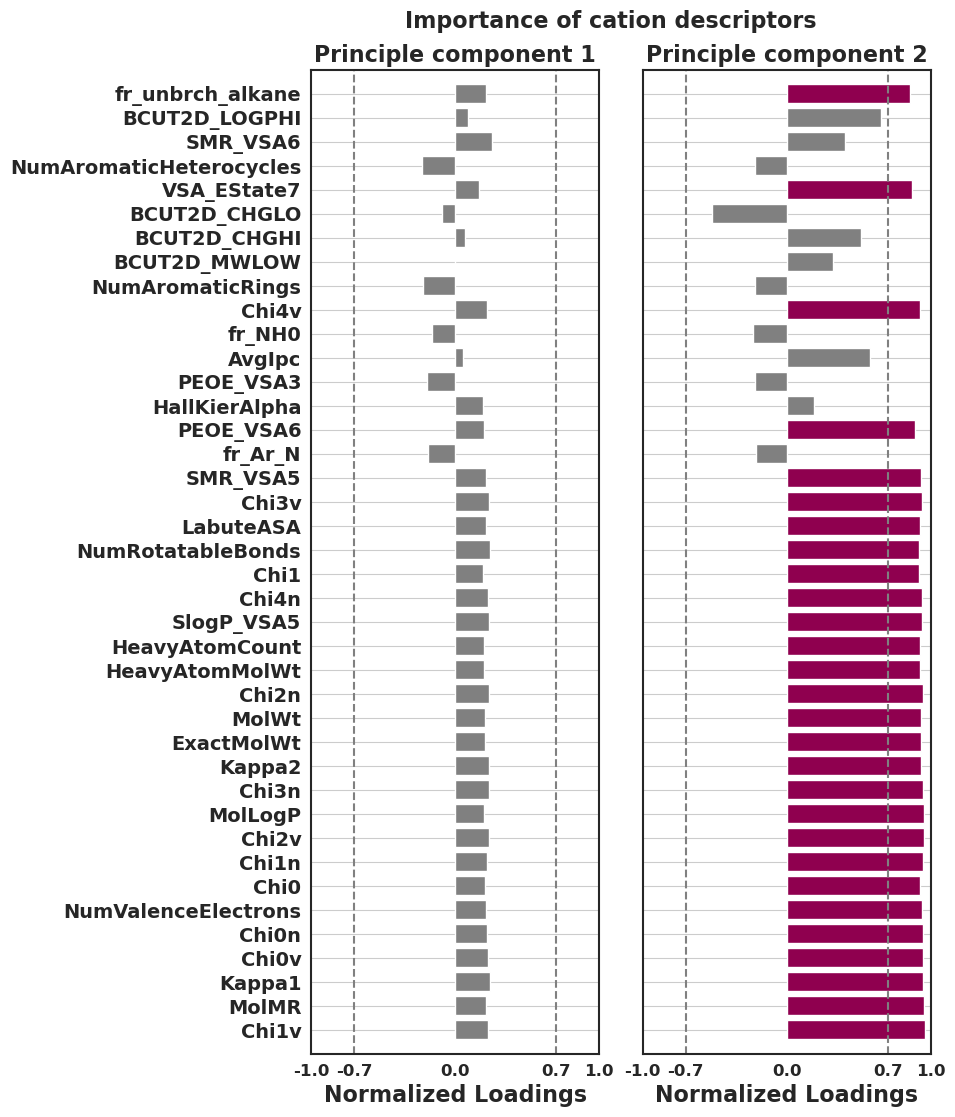

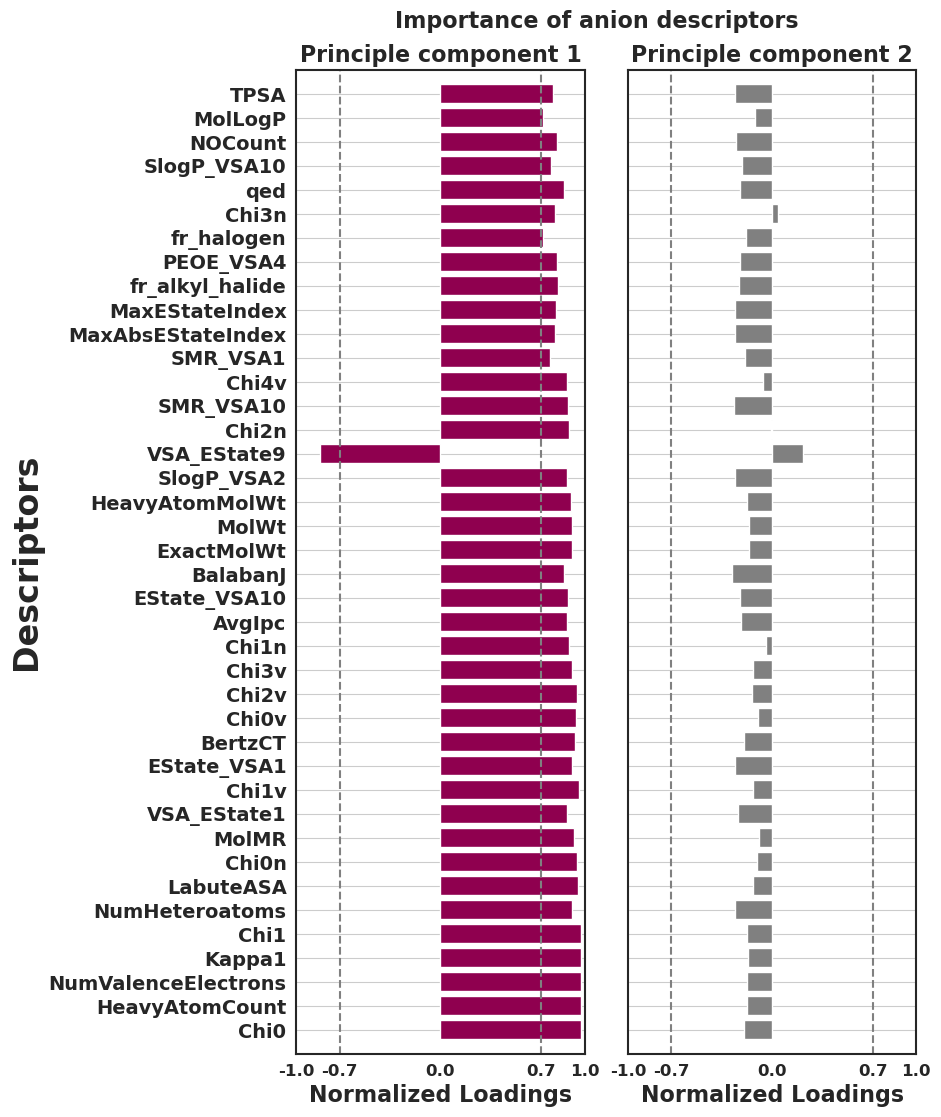

In [57]:
#Features loadings
loadings = (pca.components_.T * np.sqrt(pca.explained_variance_))

ntop = 40
n_pc = 2
X = np.zeros(ntop)
sort_idxs = np.argsort(np.absolute(loadings).sum(axis=1)) #features sorted by their overall importance

for selection in ['cation','anion']:
    select_desc_idxs = [i for i, col in enumerate(df_ilcom_desc.columns) if f'_{selection}' in col]
    mask = np.isin(sort_idxs, select_desc_idxs)
    ntop_idxs = sort_idxs[mask][:ntop]
    ntop_names = [name.replace(f'_{selection}', "") for name in df_ilcom_desc.columns[ntop_idxs]]

    Y = loadings[ntop_idxs]
    
    fig, axes = plt.subplots(1, n_pc, figsize=(8, 12))
    fig.suptitle(f'Importance of {selection} descriptors', fontsize=16, fontweight='bold')
    for x in range(0, n_pc):    
        Y_ = Y[:,x]
        ax = axes[x]
        ax.set_title(f'Principle component {x+1}', fontsize=16, fontweight='bold')
        ax.barh(ntop_names, Y_, color=['#8F004F' if abs(y) > 0.7 else 'grey' for y in Y_])
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 40)
        ax.axvline(x=0.7, color='grey', linestyle='--')
        ax.axvline(x=-0.7, color='grey', linestyle='--')
        
        ax.set_xticks([-1, -0.7, 0, 0.7, 1])
        ax.set_yticks([i for i in range(40)])
        ax.set_yticklabels(ntop_names, fontsize=14, fontweight='bold')
        ax.set_xticklabels(ax.get_xticks(), fontsize=12, rotation=0, fontweight='bold')
        ax.grid(axis='y')
        ax.set_xlabel('Normalized Loadings', fontsize=16, fontweight='bold')
        if x!=0:
            ax.set_yticklabels('')
        if x == 0 and selection=='anion':
            ax.set_ylabel('Descriptors', fontsize=24, fontweight='bold')
            
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
        
    plt.subplots_adjust(wspace=0.15, top=0.93)  # Adjust the width space between the plots
    # Show the plot
    #plt.savefig(f'pictures/feature-loadings-{selection}.svg', dpi=300, format='svg', bbox_inches='tight')
    plt.show()

In [22]:
# import dash
# from dash import dcc
# from dash import html
# import plotly.graph_objs as go
# from dash.dependencies import Input, Output
# import base64
# from io import BytesIO
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage

In [ ]:
# graph_component = dcc.Graph(
#     id='il_pca',
#     config={'displayModeBar': True},
#     figure={
#         'data': [
#             go.Scattergl(
#                 x=df[~df['commercial']]['PC1'],
#                 y=df[~df['commercial']]['PC2'],
#                 mode='markers',
#                 marker={
#                     'size': 2,
#                     'color': 'blue',
#                     'line': {'width': 0.5, 'color': 'white'}
#                 },
#                 name="Natural IL"
#             ),
#             go.Scattergl(
#                 x=df[df['commercial']]['PC1'],
#                 y=df[df['commercial']]['PC2'],
#                 mode='markers',
#                 opacity=0.8,
#                 marker={
#                     'size': 7,
#                     'color': 'purple',
#                     'line': {'width': 0.5, 'color': 'white'}
#                 },
#                 name="Commercial IL"
#             )
#         ],
#         'layout': go.Layout(
#             height=400,
#             xaxis={'title': 'Principal component 1'},
#             yaxis={'title': 'Principal component 2'},
#             margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
#             legend={'x':30, 'y': 30}
#         )
#     }
# )

# image_component = html.Img(id="structure-image")

# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
# app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# app.layout = html.Div([
#     html.Div([graph_component]),
#     html.Div([image_component])
# ])

# @app.callback(
#     Output('structure-image', 'src'),
#     [Input('il_pca', 'selectedData')])
# def display_selected_data(clickData):
#     structs_per_row = 6
#     empty_plot = "data:image/gif;base64,R0lGODlhAQABAAAAACwAAAAAAQABAAA="
#     if selectedData:
#         if len(selectedData['points']) == 0:
#             return empty_plot
#         match_idx = [x['pointIndex'] for x in selectedData['points']]
#         match_df = df.iloc[match_idx]
#         smiles_list = list(match_df['smiles_il'])
#         #name_list = [f'CAS: {cas}' if pd.notna(cas) else f'KEGG: {kegg1} {kegg2}' 
#                      #for cas, kegg1, kegg2 in zip(match_df['cas'].tolist(), 
#                       #                              match_df['KEGG_id_cation'].tolist(),
#                        #                             match_df['KEGG_id_anion'].tolist()
#                         #                          )]
#         #name_list = list(match_df['cas'])
#         mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
#         img = MolsToGridImage(mol_list, molsPerRow=structs_per_row, legends=name_list)
#         buffered = BytesIO()
#         src_str = img
#         buffered = BytesIO(img.data)
#         #img.save(buffered, format="JPEG")
#         encoded_image = base64.b64encode(buffered.getvalue())
#         src_str = 'data:image/png;base64,{}'.format(encoded_image.decode())
#     else:
#         return empty_plot
#     return src_str

# if __name__ == '__main__':
#     import socket
#     hostname = socket.gethostname()
#     IPAddr = socket.gethostbyname(hostname)    
#     app.run_server(debug=True,host=IPAddr)

In [31]:
# trace = go.Scatter(
#     x=df_ilcom.PC1,
#     y=df_ilcom.PC2,
#     name="Commercial IL",
#     mode='markers',
#     opacity=1,
#     marker=dict(
#         size=8,
#         color='#8F004F',
#         line=dict(width=0.25, color='white')
#     )
# )

# trace_natural=go.Scatter(
#                 x=df_ilnat.PC1.sample(n=50000, replace=False, random_state=5378),
#                 y=df_ilnat.PC2.sample(n=50000, replace=False, random_state=5378),
#                 mode='markers',
#                 opacity=0.7,
#                 marker={
#                     'size': 1,
#                     'color': '#370AFD',
#                     'line': {'width': 0.25, 'color': 'white'}
#                 },
#                 name="Natural IL",
#             )

# layout = go.Layout(
#     height=600,
#     width=1200,
#     template="simple_white",
#     title='Principal Component Mapping of Ionic Liquids',
#     title_x=0.45,
#     title_font=dict(size=28),
#     xaxis=dict(
#         title='Principal component 1',
#         title_font=dict(size=24),
#         range=[-15, 35], 
#         ticks='',
#         dtick=5,
#         tickfont=dict(size=18),
#         showgrid=True,
#         zeroline=True, 
#         zerolinewidth=1, 
#         zerolinecolor="black",
#         showline=False,
#     ),
#     yaxis=dict(
#         title='Principal component 2',
#         title_font=dict(size=24),
#         range=[-20, 30],
#         ticks='',
#         dtick=5,
#         tickfont=dict(size=18),
#         showgrid=True,
#         zeroline=True, 
#         zerolinewidth=1, 
#         zerolinecolor="black",
#         showline=False,
#     )
# )
# point_smiles = ''
# top49_smiles =''

# fig = go.Figure(data=[trace_natural], layout=layout)

# app = dash.Dash(__name__)

# app.layout = html.Div([
#     dcc.Graph(id='pca', figure=fig),
#     html.Img(id="structure-image")
# ])

# @app.callback(
#     [Output('pca', 'figure'),
#     Output('structure-image', 'src')],
#     [Input('pca', 'clickData')])
# def display_click_data(clickData):
#     updated_fig = go.Figure(data=[trace_natural], layout=layout)
#     updated_fig.add_trace(trace)
#     empty_image = "data:image/gif;base64,R0lGODlhAQABAAAAACwAAAAAAQABAAA="
    
#     if clickData:
        
#         point_idx = clickData['points'][0]['pointIndex']
#         point_features = ilcom_features_transformed[point_idx]
#         global point_smiles
#         point_smiles = df_ilcom.iloc[point_idx]['smiles_il']
#         point_name = df_ilcom.iloc[point_idx]['cas']
        
#         distances = np.linalg.norm(ilnat_features_transformed - point_features, axis=1)
#         top49_idxs = np.argsort(distances)[:49]
#         top49_df = df_ilnat.iloc[top49_idxs]
#         global top49_smiles
#         top49_smiles = top49_df['smiles_il'].tolist()
#         top49_names = [f'{id1} {id2}' for id1, id2 in zip(top49_df['KEGG_id_cation'].tolist(), 
#                                                           top49_df['KEGG_id_anion'].tolist())]
        
#         mol_list = [Chem.MolFromSmiles(smiles) for smiles in chain([point_smiles], top49_smiles)]
#         names_list = [name for name in chain([point_name], top49_names)]
#         img = MolsToGridImage(mol_list, molsPerRow=5, legends=names_list)
#         buffered = BytesIO()
#         src_str = img
#         buffered = BytesIO(img.data)
#         image = Image.open(buffered)
#         image.save('ILs.png')
#         encoded_image = base64.b64encode(buffered.getvalue())
#         src_str = 'data:image/png;base64,{}'.format(encoded_image.decode())

#         additional_trace = go.Scatter(
#             x=df_ilnat.iloc[top49_idxs]['PC1'], y=df_ilnat.iloc[top49_idxs]['PC2'],
#             mode='markers',
#             marker=dict(size=3, color='#D11010',line=dict(width=0.25, color='white')),
#             name='Closest Analogs'
#         )
#         highlight_trace = go.Scatter(
#             x=[df_ilcom.loc[point_idx, 'PC1']], y=[df_ilcom.loc[point_idx, 'PC2']],
#             marker=dict(size=12, symbol='circle-open', color='orange'),
#             name='Selected'
#         )
#         updated_fig.add_trace(additional_trace)
#         updated_fig.add_trace(highlight_trace)
#         updated_fig.update_layout(legend=dict(font=dict(size=20),itemsizing="constant"))
#         updated_fig.data[3].update(showlegend=False)
#         updated_fig.write_image('pca.svg', format='svg')
        
        
#     else:
#         return updated_fig, empty_image
#     return updated_fig, src_str

# if __name__ == '__main__':
#     import socket
#     hostname = socket.gethostname()
#     IPAddr = socket.gethostbyname(hostname)    
#     app.run_server(debug=True,host=IPAddr)

In [32]:
# from rdkit.Chem import Draw

In [33]:
# from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import rdDepictor
# from rdkit.Chem.Draw import rdMolDraw2D
# from IPython.display import SVG

# def moltosvg(mol, molSize = (600,600), kekulize = True):
#     mc = Chem.Mol(mol.ToBinary())
#     if kekulize:
#         try:
#             Chem.Kekulize(mc)
#         except:
#             mc = Chem.Mol(mol.ToBinary())
#     if not mc.GetNumConformers():
#         rdDepictor.Compute2DCoords(mc)
#     drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
#     drawer.drawOptions().minFontSize = 42
#     drawer.drawOptions().dotsPerAngstrom = 1000
#     drawer.drawOptions().bondLineWidth = 3.5
#     drawer.DrawMolecule(mc)
#     drawer.FinishDrawing()
#     svg = drawer.GetDrawingText()
#     return svg.replace('svg:','')
    
# with open("selected_commercial.svg", "w") as file:
#     file.write(moltosvg(Chem.MolFromSmiles(point_smiles)))

# for i, smi in enumerate(top49_smiles):
#     with open(f"{i}_analog.svg", "w") as file:
#         file.write(moltosvg(Chem.MolFromSmiles(smi)))

In [ ]:
# graph_component = dcc.Graph(
#     id='il_pca',
#     config={'displayModeBar': True},
#     figure={
#         'data': [
#             go.Scattergl(
#                 x=df[~df['commercial']]['PC1'],
#                 y=df[~df['commercial']]['PC2'],
#                 mode='markers',
#                 opacity=0.7,
#                 marker={
#                     'size': 2,
#                     'color': 'blue',
#                     'line': {'width': 0.5, 'color': 'white'}
#                 },
#                 name="Natural IL"
#             ),
#             go.Scattergl(
#                 x=df[df['commercial']]['PC1'],
#                 y=df[df['commercial']]['PC2'],
#                 mode='markers',
#                 opacity=0.7,
#                 marker={
#                     'size': 7,
#                     'color': 'purple',
#                     'line': {'width': 0.5, 'color': 'white'}
#                 },
#                 name="Commercial IL"
#             )
#         ],
#         'layout': go.Layout(
#             height=400,
#             xaxis={'title': 'Principal component 1'},
#             yaxis={'title': 'Principal component 2'},
#             margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
#             legend={'x':30, 'y': 30}, #'font' : dict(family = "Courier", size = 30, color = "black"), 'itemsizing':'constant'},
#             hovermode=False#,
#             #dragmode='select'
#         )
#     }
# )

# image_component = html.Img(id="structure-image")

# external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
# app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# app.layout = html.Div([
#     html.Div([graph_component]),
#     html.Div([image_component]),
#     dcc.Store(id='click-count', data=0)
# ])

# # @app.callback(
# #     Output('structure-image', 'src'),
# #     [Input('il_pca', 'selectedData')])
# # def display_selected_data(selectedData):
# #     structs_per_row = 6
# #     empty_plot = "data:image/gif;base64,R0lGODlhAQABAAAAACwAAAAAAQABAAA="
# #     if selectedData:
# #         if len(selectedData['points']) == 0:
# #             return empty_plot
# #         match_idx = [x['pointIndex'] for x in selectedData['points']]
# #         match_df = df.iloc[match_idx]
# #         smiles_list = list(match_df['smiles_il'])
# #         name_list = [f'CAS: {cas}' if pd.notna(cas) else f'KEGG: {kegg1} {kegg2}' 
# #                      for cas, kegg1, kegg2 in zip(match_df['cas'].tolist(), 
# #                                                     match_df['KEGG_id_cation'].tolist(),
# #                                                     match_df['KEGG_id_anion'].tolist()
# #                                                   )]
# #         #name_list = list(match_df['cas'])
# #         mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
# #         img = MolsToGridImage(mol_list, molsPerRow=structs_per_row, legends=name_list)
# #         buffered = BytesIO()
# #         src_str = img
# #         buffered = BytesIO(img.data)
# #         #img.save(buffered, format="JPEG")
# #         encoded_image = base64.b64encode(buffered.getvalue())
# #         src_str = 'data:image/png;base64,{}'.format(encoded_image.decode())
# #     else:
# #         return empty_plot
# #     return src_str
# @app.callback(
#     Output('click-count', 'data'),
#     Output('structure-image', 'src'),
#     Input('il_pca', 'clickData'),
#     Input('click-count', 'data')
# )

# def display_clicked_data(clickData, click_count):
#     structs_per_row = 6
#     print(clickData, n)
#     click_count+=1
#     empty_plot = "data:image/gif;base64,R0lGODlhAQABAAAAACwAAAAAAQABAAA="
#     if clickData:
#         if len(clickData['points']) == 0:
#             return empty_plot
#         match_idx = clickData['points'][0]['pointIndex']
#         match_df = df.iloc[[match_idx]]
#         smiles_list = list(match_df['smiles_il'])
#         name_list = [f'CAS: {cas}' if pd.notna(cas) else f'KEGG: {kegg1} {kegg2}' 
#                      for cas, kegg1, kegg2 in zip(match_df['cas'].tolist(), 
#                                                     match_df['KEGG_id_cation'].tolist(),
#                                                     match_df['KEGG_id_anion'].tolist()
#                                                   )]
#         #name_list = list(match_df['cas'])
#         mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
#         img = MolsToGridImage(mol_list, molsPerRow=structs_per_row, legends=name_list)
#         buffered = BytesIO()
#         src_str = img
#         buffered = BytesIO(img.data)
#         #img.save(buffered, format="JPEG")
#         encoded_image = base64.b64encode(buffered.getvalue())
#         src_str = 'data:image/png;base64,{}'.format(encoded_image.decode())
#     else:
#         return empty_plot
#     return src_str, click_count

# if __name__ == '__main__':
#     import socket
#     hostname = socket.gethostname()
#     IPAddr = socket.gethostbyname(hostname)    
#     app.run_server(debug=True,host=IPAddr)

In [ ]:
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D, MolsMatrixToGridImage

In [ ]:
# mols = [Chem.MolFromSmiles(df_il.iloc[indices[idx]]['0']), Chem.MolFromSmiles(df_il.iloc[indices[idx]]['1'])]
# MolsToGridImage(mols=mols,
#                molsPerRow=2)

In [ ]:
# trace = go.Scattergl(
#     x=df_ilcom.PC1,
#     y=df_ilcom.PC2,
#     name="Commercial IL",
#     mode='markers',
#     opacity=1,
#     marker=dict(
#         size=8,
#         color='#8F004F',
#         line=dict(
#             width=0.5, 
#             color='white'
#         )
#     )
# )

# layout = go.Layout(
#     height=600,
#     width=1200,
#     template="simple_white",
#     title='PC mapping of IL',
#     xaxis=dict(
#         title='Principal component 1',
#         title_font=dict(size=24),
#         range=[-15, 35], 
#         ticks='',
#         dtick=5,
#         tickfont=dict(size=18),
#         showgrid=True,
#         zeroline=True, 
#         zerolinewidth=1, 
#         zerolinecolor="black",
#         showline=False,
#     ),
#     yaxis=dict(
#         title='Principal component 2',
#         title_font=dict(size=24),
#         range=[-20, 30],
#         ticks='',
#         dtick=5,
#         tickfont=dict(size=18),
#         showgrid=True,
#         zeroline=True, 
#         zerolinewidth=1, 
#         zerolinecolor="black",
#         showline=False,
#     )
# )

# fig = go.Figure(data=[trace], layout=layout)

# app = dash.Dash(__name__)

# app.layout = html.Div([
#     dcc.Graph(id='pca', figure=fig),
#     html.Img(id="structure-image")
# ])

# @app.callback(
#     Output('structure-image', 'src'),
#     [Input('pca', 'selectedData')])
# def display_selected_data(selectedData):
#     structs_per_row = 6
#     empty_plot = "data:image/gif;base64,R0lGODlhAQABAAAAACwAAAAAAQABAAA="
#     if selectedData:
#         if len(selectedData['points']) == 0:
#             return empty_plot
#         match_idx = [x['pointIndex'] for x in selectedData['points']]
#         match_df = df_ilcom.iloc[match_idx]
#         smiles_list = list(match_df['smiles_il'])
#         name_list = list(match_df['cas'])
#         mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
#         img = MolsToGridImage(mol_list, molsPerRow=structs_per_row, legends=name_list)
#         buffered = BytesIO()
#         src_str = img
#         buffered = BytesIO(img.data)
#         #img.save(buffered, format="JPEG")
#         encoded_image = base64.b64encode(buffered.getvalue())
#         src_str = 'data:image/png;base64,{}'.format(encoded_image.decode())
#     else:
#         return empty_plot
#     return src_str

# if __name__ == '__main__':
#     import socket
#     hostname = socket.gethostname()
#     IPAddr = socket.gethostbyname(hostname)    
#     app.run_server(debug=True,host=IPAddr)